# Initialisation

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image

from keras import layers
from keras.applications import mobilenet_v2
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import seaborn as sns

import time
import pathlib

# from ultralytics import YOLO

# import torch

2025-12-12 02:21:31.963747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765491691.980060   78976 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765491691.987880   78976 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765491692.028848   78976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765491692.028872   78976 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765491692.028874   78976 computation_placer.cc:177] computation placer alr

In [3]:
keras.version()

'3.11.2'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Constants
DATA_SRC = 'garbage_classification/'
MODEL_PATH = "./garbage_classification.keras"
FINETUNED_MODEL_PATH = "./garbage_classification_finetuned.keras"
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

BATCH_SIZE = 32
EPOCHS = 20
SEED = 123

# Model Preparation

In [6]:
# Create the dataset (ds)
garbage_directory = pathlib.Path(DATA_SRC)
ds = image_dataset_from_directory(
    directory=garbage_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
)

Found 15515 files belonging to 12 classes.


I0000 00:00:1765491696.509470   78976 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4220 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [7]:
classes = ds.class_names
len_classes = len(classes)
print(f"Detected classes: {classes}\nClass size: {len_classes}")

Detected classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Class size: 12


In [8]:
# Apply the split to the dataset. 
total_batches = tf.data.experimental.cardinality(ds).numpy()
train_size = int(total_batches * TRAIN_SIZE)
val_size = int(total_batches * VAL_SIZE)
test_size = total_batches - train_size - val_size

if train_size + val_size + test_size != total_batches:
    print("ERROR: Invalid split sizes.")
    exit(1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")
print(f"Total batches found: {total_batches}")

Train size: 388
Validation size: 48
Test size: 49
Total batches found: 485


In [9]:
# Split the dataset into train, validation and test. Each taking their respective sizes
train_ds = ds.take(train_size)
leftover_ds = ds.skip(train_size)
val_ds = leftover_ds.take(val_size)
test_ds = leftover_ds.skip(val_size)

print(f"Train size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_ds).numpy()}")

Train size: 388
Validation size: 48
Test size: 49


## Balancing Class Weights

In [10]:
# VERY IMPORTANT STEP! This ensures reliability since our dataset is not balanced. 
all_labels = []

for image, label in train_ds.unbatch():
    all_labels.append(label.numpy())

y_train_one_hot = np.array(all_labels)
y_train_int = np.argmax(y_train_one_hot, axis=1)

print(f"Total training samples processed: {len(y_train_int)}")

Total training samples processed: 12416


2025-12-12 02:21:40.174613: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
classes_np = np.arange(len_classes)

# Calculate the weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes_np,
    y=y_train_int
)

class_weight_dict = dict(zip(classes_np, class_weights))

print("Weight distribution for the following dataset:")
for class_index, weight in class_weight_dict.items():
    print(f"Category {class_index}  ({classes[class_index]}) weight: {weight:.3f}")

Weight distribution for the following dataset:
Category 0  (battery) weight: 1.413
Category 1  (biological) weight: 1.326
Category 2  (brown-glass) weight: 2.125
Category 3  (cardboard) weight: 1.457
Category 4  (clothes) weight: 0.242
Category 5  (green-glass) weight: 2.009
Category 6  (metal) weight: 1.685
Category 7  (paper) weight: 1.233
Category 8  (plastic) weight: 1.484
Category 9  (shoes) weight: 0.652
Category 10  (trash) weight: 1.848
Category 11  (white-glass) weight: 1.648


In [12]:
# Alter the image in various ways so that the model is more robust
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])

In [13]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=4, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

# Plateau will help to optimize the training  passively as the epochs go by.
plateau = ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

# This will actively monitor the learning process and save the best model.
checkpoint = ModelCheckpoint("garbage_classification_checkpoint.keras", monitor='val_categorical_accuracy', save_best_only=True,mode='max',verbose=1)

callbacks = [early_stop, plateau, checkpoint]

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
def augment_ds(ds, augment=False):
    if augment:
        ds = ds.map(lambda a, b: (data_augmentation(a, training=True), b),
        num_parallel_calls=AUTOTUNE
        
        )
    ds = ds.cache()
    if augment:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
# We want to augment the training dataset only
# Helps model recognize variations of the image
train_ds = augment_ds(train_ds, augment=True)
val_ds = augment_ds(val_ds, augment=False)
test_ds = augment_ds(test_ds, augment=False)

In [16]:
# Preprocess the image, resize and normalize
def preprocess_model_input(img):
    return mobilenet_v2.preprocess_input(img)

# Model Training

In [17]:
# Here we use transfer learning
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
# Preprocssessing to handle the image sizes
model.add(Lambda(preprocess_model_input))
model.add(mobile_model)
# model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.12))

model.add(Dense(len_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,358,284 (70.03 MB)

 Trainable params: 16,099,404 (61.41 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

model.save(MODEL_PATH)

Epoch 1/20


2025-12-12 02:21:54.766525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 255 of 1000
2025-12-12 02:22:07.106364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 364 of 1000
2025-12-12 02:22:18.041126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 366 of 1000
2025-12-12 02:22:18.521562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1765491738.950297   79663 service.cc:152] XLA service 0x7f3808012bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765491738.952882   79663 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-12-12 02:22:19.600272: I tensorflow/compiler/mlir/tensorflow/utils/dump_m

388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - categorical_accuracy: 0.5440 - loss: 1.6087
Epoch 1: val_categorical_accuracy improved from None to 0.90755, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 119s 167ms/step - categorical_accuracy: 0.6729 - loss: 1.1867 - val_categorical_accuracy: 0.9076 - val_loss: 0.3074 - learning_rate: 0.0010
Epoch 2/20
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.8355 - loss: 0.5945
Epoch 2: val_categorical_accuracy improved from 0.90755 to 0.92383, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - categorical_accuracy: 0.8379 - loss: 0.5762 - val_categorical_accuracy: 0.9238 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.8960 - loss: 0.3647
Epoch 3: val_categorical_accuracy did not improve from 0.92383
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - categorical_accuracy: 0.

2025-12-12 02:24:12.085652: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269376 bytes after encountering the first element of size 19269376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9281 - loss: 0.2345
Epoch 4: val_categorical_accuracy did not improve from 0.92383
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - categorical_accuracy: 0.9236 - loss: 0.2469 - val_categorical_accuracy: 0.9193 - val_loss: 0.2703 - learning_rate: 0.0010
Epoch 5/20
 10/388 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - categorical_accuracy: 0.9289 - loss: 0.2807

2025-12-12 02:24:19.961859: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269376 bytes after encountering the first element of size 19269376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9459 - loss: 0.1795
Epoch 5: val_categorical_accuracy improved from 0.92383 to 0.92513, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - categorical_accuracy: 0.9427 - loss: 0.1887 - val_categorical_accuracy: 0.9251 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 6/20
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9595 - loss: 0.1257
Epoch 6: val_categorical_accuracy improved from 0.92513 to 0.92578, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - categorical_accuracy: 0.9548 - loss: 0.1396 - val_categorical_accuracy: 0.9258 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9656 - loss: 0.1020
Epoch 7: val_categorical_accuracy improved from 0.92578 to 0.92839, saving model to garbage_classification_checkpoint.keras
388/388 

# Fine-Tuning

In [19]:
def freeze_model(model, layers_to_freeze):
    base_model = model.layers[1]
    base_model.trainable = True
    for layer in base_model.layers[:layers_to_freeze]:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-5),
        metrics=['categorical_accuracy']
    )
    return model

In [20]:
# Unfreeze x layers
new_model = freeze_model(model, 120)
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,358,284 (70.03 MB)

 Trainable params: 17,724,300 (67.61 MB)

 Non-trainable params: 633,984 (2.42 MB)

In [21]:
# Train
history_tuned = new_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

model.save(FINETUNED_MODEL_PATH)

Epoch 1/20
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.8854 - loss: 0.3632
Epoch 1: val_categorical_accuracy improved from 0.93034 to 0.93164, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - categorical_accuracy: 0.8972 - loss: 0.3185 - val_categorical_accuracy: 0.9316 - val_loss: 0.2848 - learning_rate: 1.0000e-05
Epoch 2/20
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.9283 - loss: 0.1854
Epoch 2: val_categorical_accuracy improved from 0.93164 to 0.93815, saving model to garbage_classification_checkpoint.keras
388/388 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - categorical_accuracy: 0.9286 - loss: 0.1921 - val_categorical_accuracy: 0.9382 - val_loss: 0.2889 - learning_rate: 1.0000e-05
Epoch 3/20
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.9430 - loss: 0.1556
Epoch 3: val_categorical_accuracy did not improve from 0.93815
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - categ

# Model Loading

In [22]:
# If you would like to reload the model, run all the code in Initialisation and Model Preparation. 
# This will load the test generator and the model
try:
    keras.config.enable_unsafe_deserialization()
    model = load_model(MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
    finetuned = load_model(FINETUNED_MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
except Exception as e:
    print("ERROR: Model has not been loaded.", e)
    exit(1)

# Model Validation

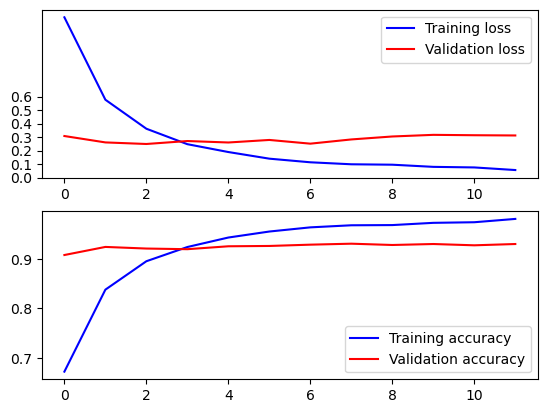

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.show()

In [24]:
def get_loss_and_accuracy(model, test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=1)
    return loss, accuracy

In [25]:
loss, accuracy = get_loss_and_accuracy(model, test_ds)
tuned_loss, tuned_accuracy = get_loss_and_accuracy(finetuned, test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

print(f"Test Loss: {tuned_loss:.4f}")
print(f"Test Accuracy: {tuned_accuracy*100:.2f}%")

2025-12-12 02:27:21.949890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269120 bytes after encountering the first element of size 19269120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9213 - loss: 0.3049

2025-12-12 02:27:36.113233: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 02:27:36.224182: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 272ms/step - categorical_accuracy: 0.9213 - loss: 0.2994
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - categorical_accuracy: 0.9283 - loss: 0.3025
Test Loss: 0.2994
Test Accuracy: 92.13%
Test Loss: 0.3025
Test Accuracy: 92.83%


In [26]:
def get_predictions(model, test_ds):
    y_pred_probs = model.predict(test_ds)

    true_labels = []

    for test_images, test_labels in test_ds:
        true_labels.extend(tf.argmax(test_labels, axis=1).numpy())

    pred_labels = np.argmax(y_pred_probs, axis=1)

    y_true = true_labels
    y_pred = pred_labels

    return y_true, y_pred

In [27]:
def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [28]:
y_true, y_pred = get_predictions(model, test_ds)
print_classification_report(y_true, y_pred)

tuned_y_true, tuned_y_pred = get_predictions(finetuned, test_ds)
print_classification_report(tuned_y_true, tuned_y_pred)

49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step


2025-12-12 02:28:05.604756: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       102
           1       0.99      0.94      0.97       106
           2       0.86      0.92      0.89        60
           3       0.87      0.91      0.89        91
           4       0.98      0.99      0.98       529
           5       0.98      0.75      0.85        59
           6       0.79      0.83      0.81        76
           7       0.92      0.84      0.88       117
           8       0.72      0.88      0.79        94
           9       0.96      0.98      0.97       194
          10       0.88      0.89      0.88        63
          11       0.81      0.71      0.76        72

    accuracy                           0.92      1563
   macro avg       0.89      0.88      0.88      1563
weighted avg       0.92      0.92      0.92      1563

49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step
              precision    recall  f1-score   support

           0       0.95      0.93     

<Axes: >

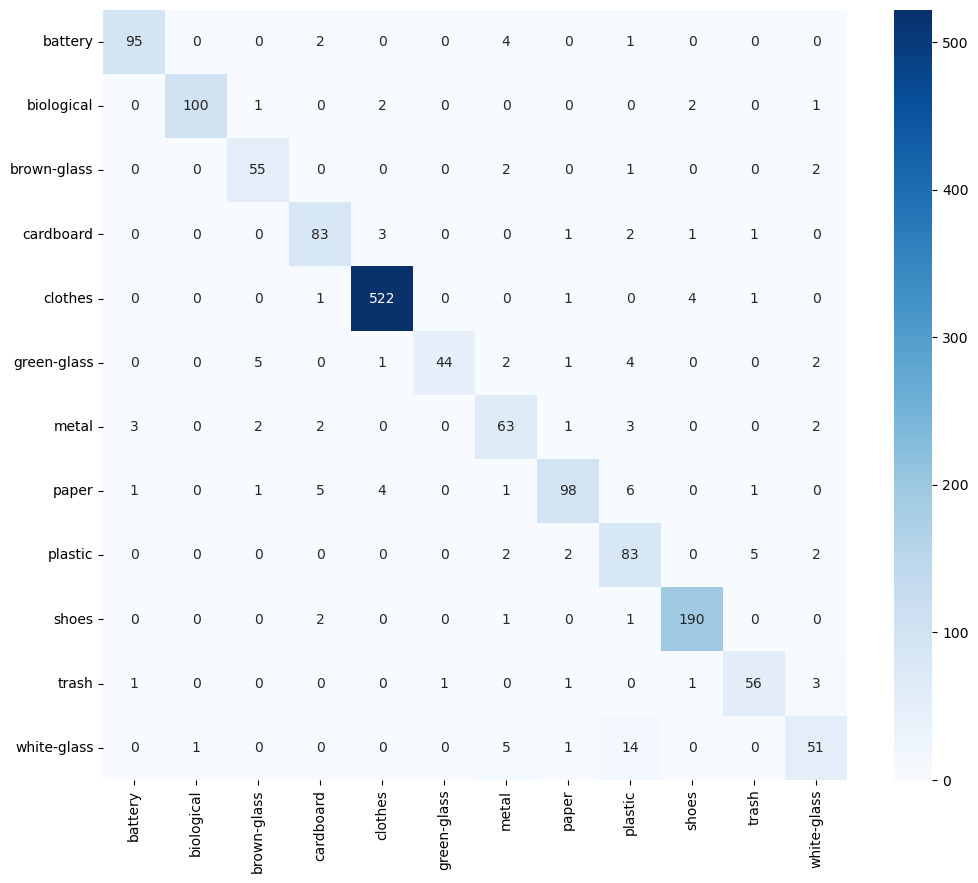

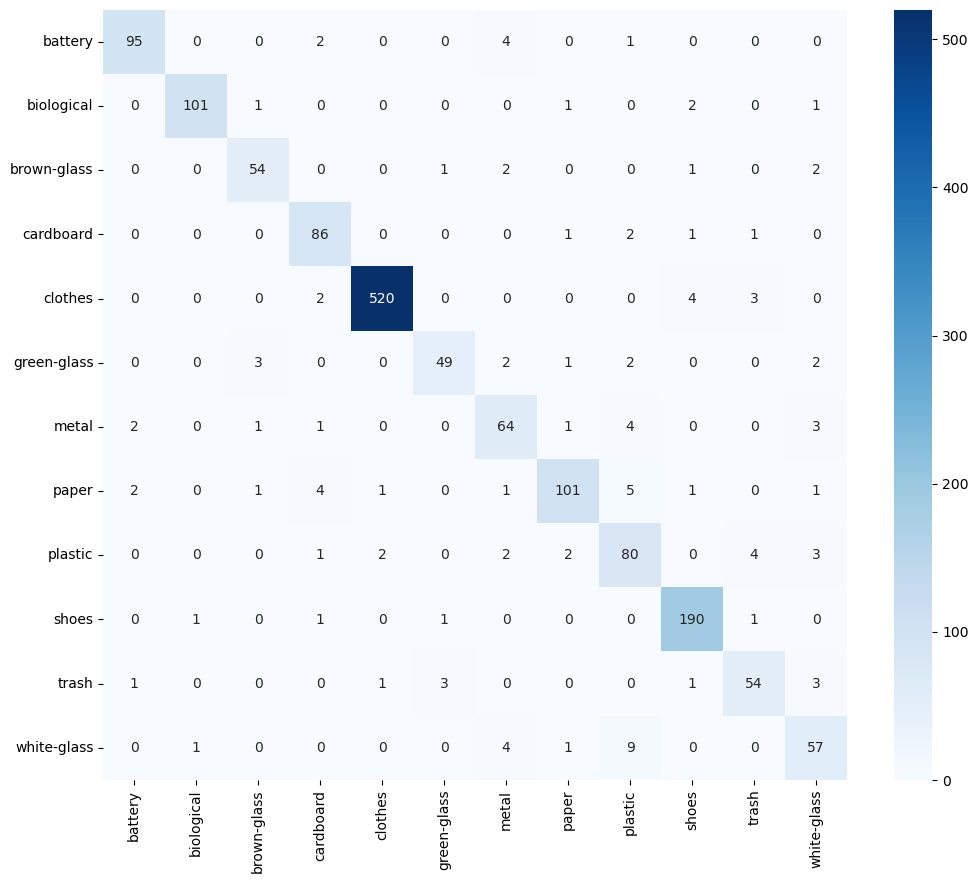

In [29]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

cm2 = confusion_matrix(tuned_y_true, tuned_y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm2, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

# Implementation with OpenCV

In [30]:
CAM_INDEX = 0
video_stream = cv2.VideoCapture(CAM_INDEX)
video_stream.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
video_stream.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
if not video_stream.isOpened():
    print("ERROR: Could not open camera.")
    exit(1)
print("Press 'ESC' to quit")

CONFIDENCE_THRESHOLD = 0.65
EPSILON = 1e-10
yolo = YOLO("yolov8s.pt")

while True:
    # Capture frame-by-frame
    ret, frame = video_stream.read()

    

    if not ret:
        print("ERROR: Can't receive frame.")
        break

    objects = yolo.predict(frame,verbose=False,imgsz=480,conf=0.30)

    for o in objects:
        for box in o.boxes:
            if yolo.names[int(box.cls[0])] == "person":
                continue
            
            x1,y1,x2,y2 = box.xyxy[0].cpu().numpy().astype(int)

            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

            cropped_dims = frame[y1:y2, x1:x2]

            if cropped_dims.size > 0:
                cropped_resized = cv2.resize(cropped_dims, IMG_SIZE)
                cropped_rgb_pixels = cv2.cvtColor(cropped_resized, cv2.COLOR_BGR2RGB)
                batch = np.expand_dims(cropped_rgb_pixels, axis=0)
                
                models_prediction = model.predict(batch, verbose=0)
    
                models_prediction_class_idx = np.argmax(models_prediction[0])
                models_prediction_class_name = classes[models_prediction_class_idx]
                confidence = models_prediction[0][models_prediction_class_idx]
                
                entropy = np.sum(
                    models_prediction[0] * np.log(models_prediction[0] + EPSILON))
                max_e = np.log(len_classes)
                normal_entropy = entropy / max_e 

                is_confident = (
                    confidence >= CONFIDENCE_THRESHOLD and 
                    normal_entropy <= 0.7
                )
                
                if is_confident:
                    text = f"{models_prediction_class_name} ({confidence * 100:.2f})%"
                else:
                    text = "UNKNOWN"
                cv2.putText(frame, text, (x1,y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2 )

  
    cv2.imshow("Garbage Classification", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        print("Exiting the program...")
        break
    elif key == ord("s"):
        print("Saving the image...")
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"image_{models_prediction_class_name}_{timestamp}.jpg"
        cv2.imwrite(filename, frame)
        

# When everything done, release the capture
video_stream.release()
cv2.destroyAllWindows()
print("Exiting the program...")

[ WARN:0@405.094] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index


ERROR: Could not open camera.
Press 'ESC' to quit


NameError: name 'YOLO' is not defined